<h1 style="color: #001a79;">Models: Exercise 2</h1>

<hr style="border-top: 1px solid #001a79;" />

<i style="color: #001a79;">Remember to do these exercises in your own notebook in your assessment repository.</i>

Fit a straight line to the following data points, using all three methods from lecture notebook.

Do you think a straight line is a good model the x any y data-points declared below?

In [1]:
# Numerical arrays
import numpy as np

x = np.array([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0])
y = np.array([0.7, 1.1, 1.5, 1.6, 1.7, 2.0, 2.3, 2.4, 2.2, 2.1, 2.4, 2.6, 2.2, 2.7, 2.5, 2.7, 2.8, 2.9, 3.1])

In [2]:
# import all other libraries for future use...

# Optimization of cost functions
import scipy.optimize as so
import scipy.stats as ss

# for generation of qq plot
import statsmodels.api as sm
import pylab as py

# for durbin watson test
from statsmodels.stats.stattools import durbin_watson

# for auto-correlation plot
from statsmodels.graphics import tsaplots

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# format plots
sns.set_style("darkgrid")


<br>

<h2 style="color: #001a79;">Fitting Straight Lines</h2>
<hr style="border-top: 1px solid rgb(0, 91, 94);" />

Given the cost function below for fitting straight lines, lets explore some methods available in python for estimating / calculating the best values of m and c.

$$ Cost(m, c) = \sum_i (y_i - mx_i - c)^2 $$

### Method 1: [numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)

In [3]:
# analytical result
m_a, c_a = np.polyfit(x, y, 1)
print(f'slope value = {m_a:.3f}\nconstant value = {c_a:.3f}')

slope value = 0.103
constant value = 1.049


### Method 2: [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [4]:
def linear_cost(MC):
    '''returns the cost for passed values of m and c'''
    # Unpack m and c
    m, c = MC
    # get cost as sum of the residuals squared
    cost = np.sum((y - m * x - c) **2)
    return cost

# return minimize results by passing linear function and 2x guesses
result = so.minimize(linear_cost, (2.0, 5.0))

# pull out optimised results of slope and constant
m_o, c_o = result.x
print(f'slope value = {m_o:.3f}\nconstant value = {c_o:.3f}')

slope value = 0.103
constant value = 1.049


### Method 3: [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

In [5]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
def f(x, m, c):
    '''returns predicted y-val given passed x, m and c vals'''
    return m * x + c

In [6]:
# Run curve_fit with default initial guesses of 1 for m and c
result = so.curve_fit(f, x, y)

# Pull out the parameters.
m_f, c_f = result[0]
print(f'slope value = {m_f:.3f}\nconstant value = {c_f:.3f}')

slope value = 0.103
constant value = 1.049


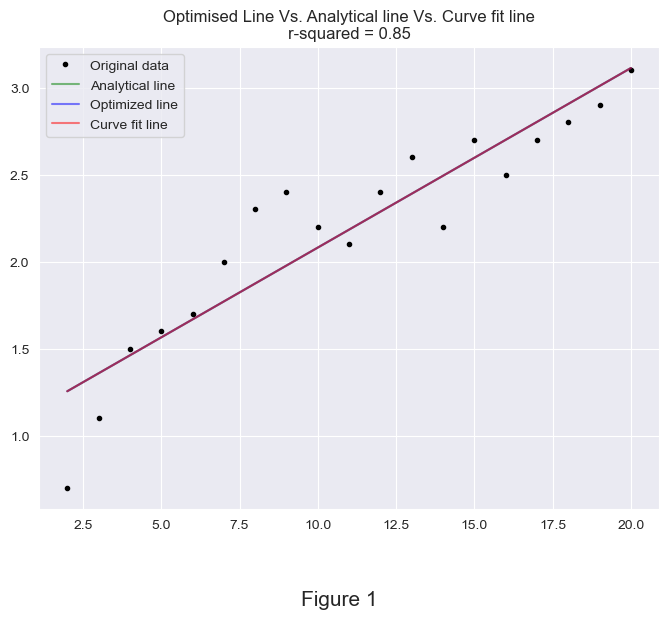

In [7]:
# Plot the best fit line from the optimization
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(x, y, 'k.', label='Original data')
ax.plot(x, m_a * x + c_a, 'g-', label = 'Analytical line', alpha = 0.5)
ax.plot(x, m_o * x + c_o, 'b-', label = 'Optimized line', alpha = 0.5)
ax.plot(x, m_f * x + c_f, 'r-', label = 'Curve fit line', alpha = 0.5)

# calc r-squared val
rsq = np.corrcoef(x, y)[0][1] ** 2

# format plot
plt.figtext(0.5, -0.05, 'Figure 1', wrap = True, horizontalalignment = 'center', fontsize = 15);
ax.set_title("Optimised Line Vs. Analytical line Vs. Curve fit line\n{}"
             .format('r-squared = %.2f' % (rsq)))
ax.legend()
plt.show()


<br>

<h2 style="color: #001a79;">Is the model a good fit?</h2>
<hr style="border-top: 1px solid rgb(0, 91, 94);" />

Lets explore some of the assumpions that need to be considered when applying a linear regression model to our data. As detailed by Sawla (2019), there are 4 principal assumptions which justify the use of a linear regression model:
1. **Linearity:** expected value of the dependant variable is a straight line function of the dependant variable.
2. **Normality:** for any given x value the surrounding y-values should be normally distributed.
3. **Homoscedasticity:** error variance should be constant.
4. **Statistical Independence of errors:** no correlation between consecutive errors (typically in time-series data).

Let's explore the assumptions above.

<br>


### 1. Linearity
***

We can see from Figure 1 above that all 3 of our straight line models somewhat fit a straight line, however there appears to be some variance between the actual values and predicted values, lets explore this variance.

In [8]:
# mean of residuals
res_mean_sq = np.sum((y - m_a * x - c_a)) / len(y)

# sum squared regression
ssr = np.sum((y - m_a * x - c_a) ** 2)

#  total sum of squares
sst = np.sum((y - np.mean(y)) ** 2)

# calc r-squared
r_sq = 1 - (ssr / sst)

print(f'mean of residuals = {res_mean_sq}')
print(f'r-squared = {r_sq:.3f}')

mean of residuals = 3.0385051200267443e-16
r-squared = 0.854


We can see that the mean of residuals is a very small value, meaning that on average there is little difference between y-actual and y-predicted using our model. Also the r-squared-value of 0.85 helps give us confidence that there is a linear correlation between the dependant and independant variable.

<br>


### 2. Normality
***

From the Shapiro test conducted we tested the null hypothesis that the residual data was drawn from a normal distribution. A p-value of 0.83 was returned which is significantly greater than 0.05 so we fail to reject the null hypothesis.


In [9]:
# get residuals into a list
residuals = [(y[i] - m_a * x[i] - c_a) for i in range(y.size)]

## code adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
shapiro_test = ss.shapiro(residuals)
print(f'statistic = {shapiro_test.statistic:.3f}\np-value {shapiro_test.pvalue:.3f}')

statistic = 0.973
p-value 0.830


Lets get a visual on the residual distribution via a histogram and normality via a Quantile-Quantile (Q-Q) plot. Sawla (2019) helps describe how Q-Q plots compare the quartiles of a normal distribution vs the quartiles of the dependant variable's distribution. The histogram below shows that the data does somewhat resemble the saught after bell-curve shape, however it is hard to tell given the numbers of data points we have to work with. The Q-Q plot in Figure 2 shows the datapoints close to the red line but forming small repeating s-shape patterns around it. In reality our dataset is very small and one should consider the Central Limit Theorem which states that as the size of sample increases, the distribution of the samples means will tend towards that of a nomral distribution [1]. I would also be possible that this pattern of deviation from residual normality is due to some time-series event causing variance.

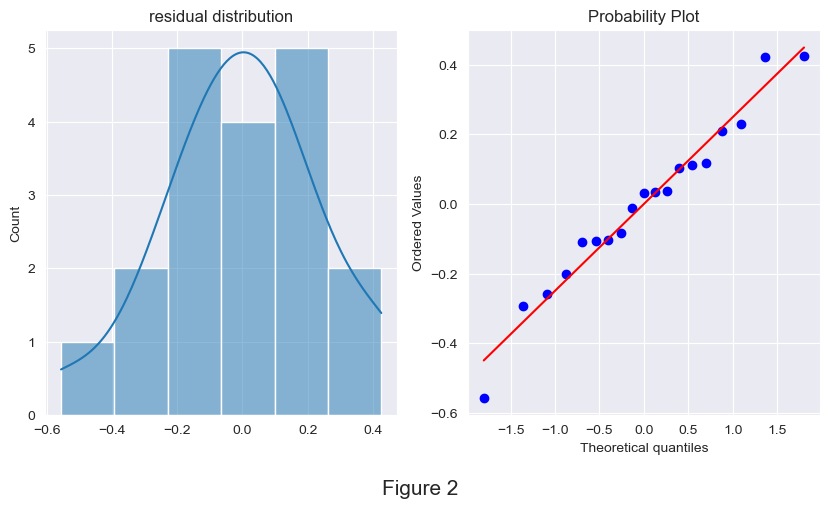

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plt.figtext(0.5, -0.05, 'Figure 2', wrap = True, horizontalalignment = 'center', fontsize = 15);

# plot histgram
sns.histplot(x = residuals, kde = True, ax = ax1)

# quantile-quantile (qq) plot 
# plot code adopdted from: https://www.kaggle.com/code/gadaadhaarigeek/q-q-plot
ss.probplot(residuals, dist="norm", plot = py)
ax1.set_title("residual distribution")
plt.show();


<br>

### 3. Homoscedasticity
***

Next lets conduct a Levene's test to challange the null hypothesis that all input samples are from populations of equal variances. We will use an alpha level of 0.05 with a *median* center attribute to model the test on a normal distribution.

In [11]:
# get y-predicted values into list 
y_pred = [(m_a * x[i] + c_a) for i in range(y.size)]

# adopted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = ss.levene(y, y_pred, center = 'median')
print(f'p-value = {p:.3f}')

p-value = 0.898


This p-value of 0.90 is significantly greater than 0.05 meaning we fail to reject the null hypothesis as it is likely that the observed variances would be repeated on subsequent sampling. Lets visualise the residual variance vs the y-predicted values (normalised) in Figure 2 below. As shown in the plot the residuals have somewhat equal variance relative to the predicted y-values (red line).

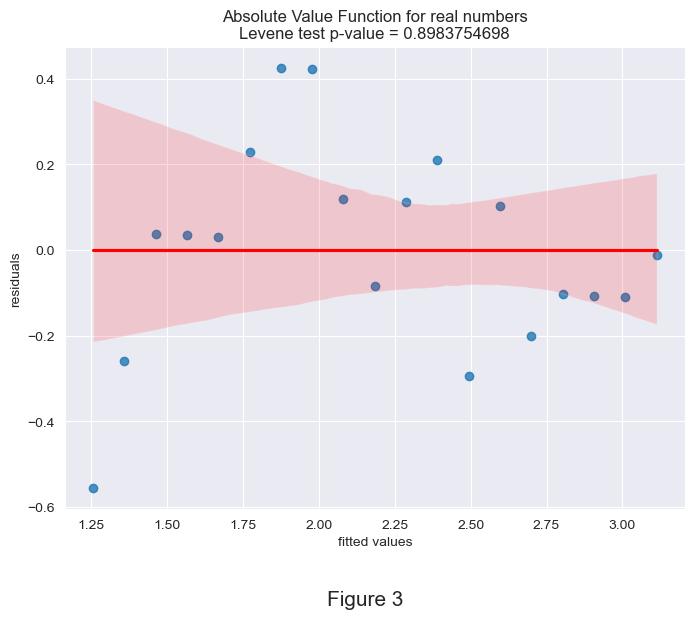

In [12]:
fig, ax = plt.subplots(figsize = (8, 6))

# plot predicted y vals (normalised) vs residuals
sns.regplot(x = y_pred, y = residuals, line_kws = {'color': 'red'})

plt.figtext(0.5, -0.05, 'Figure 3', wrap = True, horizontalalignment = 'center', fontsize = 15);
plt.title(f'Absolute Value Function for real numbers\nLevene test p-value = {p:.10f}')
plt.xlabel("fitted values")
plt.ylabel("residuals")
plt.show();


<br>

### 3. Statistical Independence of errors
***

Its possible that the almost intermittent deviation from the line of best fit in Figure 1 and the s-shape deviation from normality in Figure 2 (Q-Q plot) are due to lagged correlation. Lets run a Durbin Waton test which can help us answer this question. The test works by comparing the sum of errors squared to the sum of the differences squared (see below for calculation). A Durbin-Walton statistic of 2 will confirm our null hypothesis that the residuals are serially uncorrelated.

In [13]:
# Durbin-Watson test library
# adopted from: https://www.geeksforgeeks.org/statsmodels-durbin_watson-in-python/
  
# Using statsmodels.durbin_watson() method
auto_corr_test = durbin_watson(residuals)
print(f'Durbin-Watson library Statistic = {auto_corr_test:.5f}')

Durbin-Watson library Statistic = 0.91998


In [14]:
# Durbin-Watson test manual
# logic applied from https://www.investopedia.com/terms/d/durbin-watson-statistic.asp

# get sum of error squared
error_sum_sq = sum(i * i for i in residuals)

# get residual list offsets for test 
res_off_l, res_off_r = residuals[1:], residuals[0 : len(residuals) - 1]

# get sum of difference squared
error_diff_sq = np.sum([(res_off_r[i] - res_off_l[i]) ** 2 for i in range(len(res_off_r))])

durbin_val = error_diff_sq / error_sum_sq
print(f'Durbin-Watson manual Statistic = {durbin_val:.5f}')

Durbin-Watson manual Statistic = 0.91998


As shown above the Durbin-Watson Statistic of 0.92 indicates a level of positive correlation. Lets leverage the auto-correlation function of statsmodels to get a visual representation on any the correlations. Figure 4 shows us that there is no auto-correlation that is significanty non-zero (i.e: no values lie outside of the shaded blue confidence interval). However based on the closeness of the value at x = 1 and the Durbin-Watson Statistic one should proceed with any assumptions that no auto-correlation exists.

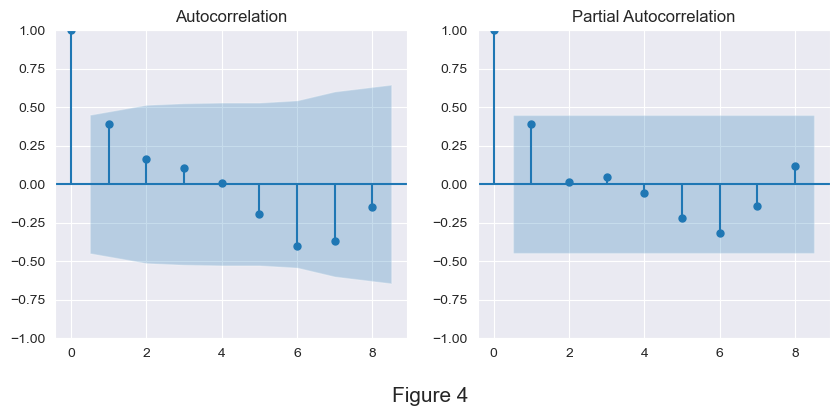

In [15]:
# documentation for plotting auto-correlation
# tps://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
lag_val = 8
sm.graphics.tsa.plot_pacf(residuals, lags = lag_val, ax=ax[1], method='ywm')
sm.graphics.tsa.plot_acf(residuals, lags = lag_val, ax=ax[0]) 
plt.figtext(0.5, -0.05, 'Figure 4', wrap = True, horizontalalignment = 'center', fontsize = 15);
plt.show();

### 2. Conclusion
***

Given the dataset and the linear model proposed in Figure 1 a straight line does not strictly violate the Linear regression assumptions, however it would be interesting explore improving the model by:
1. Increasing the degrees of freedom in our linear model, for example a quadtraic approach may curve the line to better fit our data.
2. Explore ways to model auto-correlation, for example imagine our x-values represented a month of the year. If this way the case one could look at incorperating this into their model to account for the spikes in the data.

<h2 style="color: rgb(0, 91, 94);">References</h2>

<hr style="border-top: 1px solid rgb(0, 91, 94);" />


[1]. Mittal, A, 2020, Why The Central Limit Theorem in Data Science?, towards data science, Available at: [Ref Link](https://aditi-mittal.medium.com/why-the-central-limit-theorem-in-data-science-be8997b95f3)<br>
(Accessed 04 November 2022).

<br>

[1]. Chandran, S, 2021, Significance of Q-Q Plots, towards data science, Available at: [Ref Link](https://towardsdatascience.com/significance-of-q-q-plots-6f0c6e31c626) <br>
(Accessed 03 November 2022).

<br>

[2]. Sawla, S, 2019, Linear Regression- Data Science Algorithm every Data Scientist should know, medium.com, Available at: [Ref Link](https://medium.com/@srishtisawla/linear-regression-data-science-algorithm-every-data-scientist-should-know-34d5fcb51c03) <br>(Accessed 02 November 2022).







<h2 style="color: rgb(0, 91, 94);">End</h2>
<hr style="border-top: 1px solid rgb(0, 91, 94);" />